CNN_LSTM_kernel_size_7x5

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Set random seed for numpy
np.random.seed(11)
# Set random seed for pytorch
torch.manual_seed(11)
# Set random seed for pytorch running in GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(11)

In [3]:
UTD_train_features = np.load('utd/UTD-single-column/sig_train_32_AI.npy',allow_pickle=True)
UTD_test_features = np.load('utd/UTD-single-column/sig_test_32_AI.npy',allow_pickle=True)
UTD_train_labels = np.load('utd/UTD-single-column/sig_train_32_labels.npy',allow_pickle=True)
UTD_test_labels = np.load('utd/UTD-single-column/sig_test_32_labels.npy',allow_pickle=True)

In [4]:
# Hyperparameters
num_epochs = 30
batch_size = 10
learning_rate = 0.0001

In [5]:
UTD_train_labels = UTD_train_labels.astype(int) - 1
UTD_test_labels = UTD_test_labels.astype(int) - 1

In [6]:
# Transform to torch tensor
tensor_UTD_train_features = torch.Tensor(UTD_train_features) 
tensor_UTD_train_labels = torch.Tensor(UTD_train_labels)
tensor_UTD_test_features = torch.Tensor(UTD_test_features) 
tensor_UTD_test_labels = torch.Tensor(UTD_test_labels)
# Add one dimension of channel
tensor_UTD_train_features = torch.unsqueeze(tensor_UTD_train_features, 1)
tensor_UTD_test_features = torch.unsqueeze(tensor_UTD_test_features, 1)
# Create datset
train_dataset_UTD = TensorDataset(tensor_UTD_train_features,tensor_UTD_train_labels)
test_dataset_UTD = TensorDataset(tensor_UTD_test_features,tensor_UTD_test_labels)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_UTD, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_UTD, batch_size=batch_size, shuffle=False)

In [8]:
for image,label in train_loader:
    print(image.size())
    print(label.size())
    break

torch.Size([10, 1, 18, 32])
torch.Size([10])


### Construct LSTM

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=7, stride=1, padding=3)  ### 10,32,18,384
        self.pool = nn.MaxPool2d(2, 2) ### 10,32,9,192 2nd layer
        self.conv2 = nn.Conv2d(32,64, kernel_size=7, stride=1, padding=3) ###10,64,9,192 3rd layer
    
    def forward(self, x):
        batch,c,h,w = x.size()
        x = self.pool(F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x))) ### 10,64,9,192/ 5,64,9,192
        x = x.view(batch,-1) ### 10,110592 
        return x

In [11]:

class CNN_LSTM(nn.Module): 
    def __init__(self):
        super(CNN_LSTM, self).__init__() ###(num_samples,timesteps,input_dim). 
        self.cnn = Cnn()
        self.rnn = nn.LSTM(
            input_size=72, ### [32 <- 216] / [64<-432]/ [128<-864] or single [32 <- 72] / [64<-144]/ [128<-288]
            hidden_size=441, 
            num_layers=1, ### change [1,3,5]
            batch_first=True)
        self.linear = nn.Linear(441,21)

    def forward(self, x):
        batch,c,h,w = x.size()
        c_out = self.cnn(x) ### 10,110592
        r_in = c_out.view(batch,128,-1) ### 10,1,8192
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        return F.log_softmax(r_out2, dim=1)


In [12]:
# Choose CPU or GPU
# model = ConvNet() #CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Combine

In [13]:
%%time
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/30], Step [100/364], Loss: 3.0406, Accuracy: 0.00%
Epoch [1/30], Step [200/364], Loss: 3.2370, Accuracy: 10.00%
Epoch [1/30], Step [300/364], Loss: 3.0204, Accuracy: 10.00%
Epoch [2/30], Step [100/364], Loss: 2.8253, Accuracy: 20.00%
Epoch [2/30], Step [200/364], Loss: 2.6582, Accuracy: 40.00%
Epoch [2/30], Step [300/364], Loss: 2.8053, Accuracy: 10.00%
Epoch [3/30], Step [100/364], Loss: 2.5988, Accuracy: 20.00%
Epoch [3/30], Step [200/364], Loss: 2.6156, Accuracy: 20.00%
Epoch [3/30], Step [300/364], Loss: 2.7774, Accuracy: 20.00%
Epoch [4/30], Step [100/364], Loss: 2.4714, Accuracy: 60.00%
Epoch [4/30], Step [200/364], Loss: 2.6625, Accuracy: 20.00%
Epoch [4/30], Step [300/364], Loss: 2.5149, Accuracy: 20.00%
Epoch [5/30], Step [100/364], Loss: 2.3545, Accuracy: 50.00%
Epoch [5/30], Step [200/364], Loss: 2.5527, Accuracy: 30.00%
Epoch [5/30], Step [300/364], Loss: 2.0490, Accuracy: 40.00%
Epoch [6/30], Step [100/364], Loss: 2.3105, Accuracy: 50.00%
Epoch [6/30], Step [200/3

In [14]:
classes = ('Swipe_left','Swipe_right','Wave',"Clap","Throw","Arm_cross","Basketball_shoot","Draw_X",
           "Draw_circle_clockwise","Draw_circle_counter","Draw_traingle","Bowling","Boxing","Baseball_swing",
          "Tennis_swing","Arm_curl","Tennis_serve","Push","Knock","Catch","Pickup_throw")

Test Accuracy of the model on the UCIHAR test images: 39.45054945054945 %


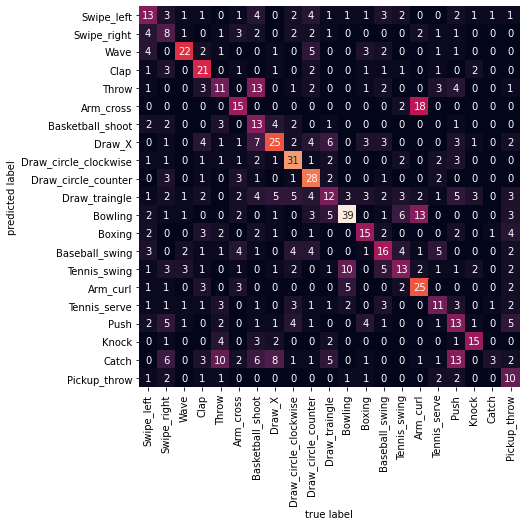

In [15]:

from sklearn import metrics
import seaborn as sns
# Test the model on GPU
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the UCIHAR test images: {} %'.format((correct / total) * 100))

mat = metrics.confusion_matrix(torch.cat(all_predictions).cpu(), torch.cat(all_labels).cpu())
plt.figure(figsize=(7,7))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');